## Load data

In [8]:
# Load the page metadatas
import json
import re
import pandas as pd
import os
import csv

from typing import List

from typing import TypedDict
#from langchain import hub
from langchain.chat_models import init_chat_model
from langchain.document_loaders import PyPDFLoader
from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain_huggingface.embeddings import HuggingFaceEmbeddings

from langgraph.graph import START, StateGraph
from langchain_huggingface import HuggingFacePipeline
from langchain_text_splitters import RecursiveCharacterTextSplitter

from sentence_transformers import CrossEncoder
from rank_bm25 import BM25Okapi

import pickle
import transformers
import torch
import tqdm
import yaml

BOOK_PAGE_OFFSET = 18
BOOK_LAST_PAGE = 640

def map_page_to_section(metadata):
    page_map = {}
    for section, sec_data in metadata.items():
        sec_start = sec_data.get("page_start")
        sec_end = sec_data.get("page_end")
        subsections = sec_data.get("subsections", {})
        for page in range(sec_start, sec_end + 1):
            page_map[page] = {"section": section, "subsection": None}
        for subsec, subsec_data in subsections.items():
            sub_start = subsec_data.get("page_start")
            sub_end = subsec_data.get("page_end")
            for page in range(sub_start, sub_end + 1):
                page_map[page] = {"section": section, "subsection": subsec}
                
    return page_map


def read_pdf_pages(pdf_path: str) -> List[str]:
    """
    Read a PDF and return a list of page texts (one string per page) using PyPDFLoader.
    """
    loader = PyPDFLoader(pdf_path)
    docs = loader.load()  # returns a list of Document objects, typically one per page
    docs = [doc.page_content for doc in docs]
    
    return docs#[:BOOK_PAGE_OFFSET + 2]


def load_config(path: str) -> dict:
    with open(path, "r") as f:
        config = yaml.safe_load(f)
    exp_signature = f"{config['chunking']['method']}_cs{config['chunking'].get('chunk_size','')}_topk_{config['top_k_candidates']}_{config['top_k_retrieval']}_{config['top_k_rerank']}"
    config["semantic_vs_path"] = os.path.join(config["data_dir"], f"sem_vs_{config['exp_name']}_{exp_signature}")
    config["keyword_vs_fname"] = os.path.join(config["data_dir"], f"keyw_vs_{config['exp_name']}_{exp_signature}.pkl")
    config["out_fname"] = os.path.join(config["data_dir"], f"out_{config['exp_name']}_{exp_signature}.csv")

    return config


config = load_config("exps/fixed_chunking_512.yml")
exists_semantic_vs = os.path.exists(config["semantic_vs_path"])

if not exists_semantic_vs:
    with open("data/book-metadata.json", "r") as f:
        book_metadata = json.load(f)

    page_to_section = map_page_to_section(book_metadata)
    pages = read_pdf_pages("data/book.pdf")
    pages = pages[BOOK_PAGE_OFFSET:BOOK_LAST_PAGE]


## Indexers Population

In [9]:
%load_ext autoreload
%autoreload 2
from chunking import *

# Keyword vector store
class BM25:
    def __init__(self, docs: List[Document]):
        self.docs = docs
        tokenized_corpus = [doc.page_content.lower().split(" ") for doc in docs]
        self.bm25 = BM25Okapi(tokenized_corpus)

    def similarity_search_with_relevance_scores(self, query, k=4):
        tokenized_query = query.lower().split(" ")
        scores = self.bm25.get_scores(tokenized_query)
        top_k_idx = scores.argsort()[::-1][:k]
        return [(self.docs[i], scores[i]) for i in top_k_idx]
    
import time
start = time.time()
# Create vector store
model_kwargs = {"device":"cpu"}
embedding_model_name = "sentence-transformers/all-mpnet-base-v2"

embeddings = HuggingFaceEmbeddings(model_name=embedding_model_name, model_kwargs=model_kwargs, 
                                  encode_kwargs={'normalize_embeddings':True})

print("Loaded embedding model:", time.time() - start)
start = time.time()
semantic_vs = Chroma(
    collection_name="example_collection",
    embedding_function=embeddings,
    persist_directory=config["semantic_vs_path"]
)

print("Loaded semantic VS:", time.time() - start)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loaded embedding model: 2.4261622428894043
Loaded semantic VS: 0.07996582984924316


In [10]:
%load_ext autoreload
%autoreload 2
from chunking import *

start = time.time()

if not exists_semantic_vs:
    chunking_fn = get_chunking_fn(config["chunking"]["method"])
    print("len pages:", len(pages), " valid pages:", len(page_to_section.keys()))
    docs = chunking_fn(page_to_section, pages, chunk_size=config["chunking"]["chunk_size"], start_page=config["start_page_num"])
    print("Number osf chunks created:", len(docs))
    semantic_vs.add_documents(docs)
    
    keyword_vs = BM25(docs)
    pickle.dump(keyword_vs, open(config["keyword_vs_fname"], "wb"))
else:
    keyword_vs = pickle.load(open(config["keyword_vs_fname"], "rb"))

print("Finished chunking and VS setup:", time.time() - start)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
len pages: 622  valid pages: 614
Number osf chunks created: 580
Finished chunking and VS setup: 41.884074687957764


## Pipeline Definition

In [11]:
%reload_ext autoreload
%autoreload 2
from retrieval import HybridRetriever, create_query_prompt
import textwrap

def get_llm():
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    model_id = "Qwen/Qwen2.5-0.5B-Instruct"
 
    def load_model_and_tokenizer(model_id):
        model_config = transformers.AutoConfig.from_pretrained(model_id)
        model = transformers.AutoModelForCausalLM.from_pretrained(
            model_id,
            trust_remote_code=True,
            config=model_config,
            device_map="auto",  # Automatically distribute the model across available devices
        )
        tokenizer = transformers.AutoTokenizer.from_pretrained(model_id)
        
        return model, tokenizer

    model, tokenizer = load_model_and_tokenizer(model_id)

    # Create the query pipeline
    query_pipeline = transformers.pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
        torch_dtype=torch.float16, 
        max_new_tokens=1000, 
        device_map="auto", 
        num_return_sequences=1,
        truncation=True,
        do_sample=True,  
        temperature=0.2,  
        pad_token_id=tokenizer.eos_token_id  
    )

    # Using the the HuggingFacePipeline class from LangChain to wrap the pipeline
    return HuggingFacePipeline(pipeline=query_pipeline)


# Initialize LLM
llm = get_llm()

hybrid_retriever = HybridRetriever(
    semantic_vs=semantic_vs,
    keyword_vs=keyword_vs,
    llm = llm
)

# Define state
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str
    sections: List[str] 
    page_nums: List[int]


# Define application steps
def retrieve(state: State):
    docs_and_relevance = hybrid_retriever.retrieve(state["question"], 
                                                   top_k=config["top_k_retrieval"], 
                                                   top_k_candidates=config["top_k_candidates"])
    #print("Retrieved documents")
    #for i, (doc, _) in enumerate(docs_and_relevance):
    #    print(f"\n--- Document {i+1} {doc.metadata.get("page_num")}---")
    #    print(textwrap.fill(doc.page_content, width=120))

    reranked_docs = hybrid_retriever.rerank(state["question"], 
                                            docs_and_relevance, 
                                            top_k=config["top_k_rerank"])
    #print("Reranked documents")
    #for i, doc in enumerate(reranked_docs):
    #    print(f"\n--- Document {i+1} {doc.metadata.get("page_num")}---")
    #    print(textwrap.fill(doc.page_content, width=120))

    return {"context": reranked_docs}

def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    sections = [doc.metadata.get("sections", "") for doc in state["context"]]
    page_nums = [doc.metadata.get("page_num", -1) for doc in state["context"]]

    prompt = create_query_prompt(state["question"], docs_content)
    response = llm.invoke(prompt)
    
    # Remove prompt from response #TODO: Enhance without including the context.
    response = response[len(prompt):].strip()
    
    return {
            "answer": response,
            "sections": sections,
            "page_nums": page_nums,
            "context": docs_content
            }

# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")

graph = graph_builder.compile()

Device set to use cuda:0


## Post-processing and Submission File Creation

In [12]:
# Post-processing
def clean_answer(answer):
    answer = re.sub("\**", "", answer)
    return re.sub("##*", "", answer)


# Read queries from data/queries.json and query to the RAG system
def create_submission(graph):
    with open("data/queries.json", "r") as f:
        queries = json.load(f)

    submission_fname = config['out_fname']
    with open(submission_fname, "w") as f:
        f.write("ID,context,answer,references\n")

    for i in tqdm.tqdm(range(len(queries))):
        response = graph.invoke({"question": queries[i]['question']})

        with open(submission_fname, "a") as f:
            distinct_refs = list({(s, p) for s, p in zip(response["sections"], response["page_nums"])})
            
            row = [queries[i]['query_id'],
                response["context"],
                clean_answer(response["answer"]),
                {"sections": [s for s, _ in distinct_refs],
                "page_nums": [p for _, p in distinct_refs]}]
            
            writer = csv.writer(f)
            writer.writerow(row)


create_submission(graph)

<>:3: SyntaxWarning: invalid escape sequence '\*'
<>:3: SyntaxWarning: invalid escape sequence '\*'
/tmp/ipykernel_290850/3179714357.py:3: SyntaxWarning: invalid escape sequence '\*'
  answer = re.sub("\**", "", answer)
  4%|▍         | 2/50 [00:35<13:39, 17.07s/it]/home/julio/Documents/professional-skills/ml/CASML/retrieval.py:105: UserWarning: Relevance scores must be between 0 and 1, got [(Document(id='15a4e7da-fc2c-431d-83af-3fcbcf7bcdf1', metadata={'page_num': 138, 'sections': 'States of Consciousness/None', 'id': 382464}, page_content=' phase that occurs between wakefulness and sleep; the period during which a person drifts off to sleep stage 2 sleep second stage of sleep; the body goes into deep relaxation; characterized by the appearance of sleep spindles stage 3 sleep third stage of sleep; deep sleep characterized by low frequency, high amplitude delta waves stimulant drug that tends to increase overall levels of neural activity; includes caffeine, nicotine, amphetamines, and 

In [13]:
from playsound import playsound
playsound('/home/julio/Music/mixkit-alarm-digital-clock-beep-989.wav')

## Results Visualization

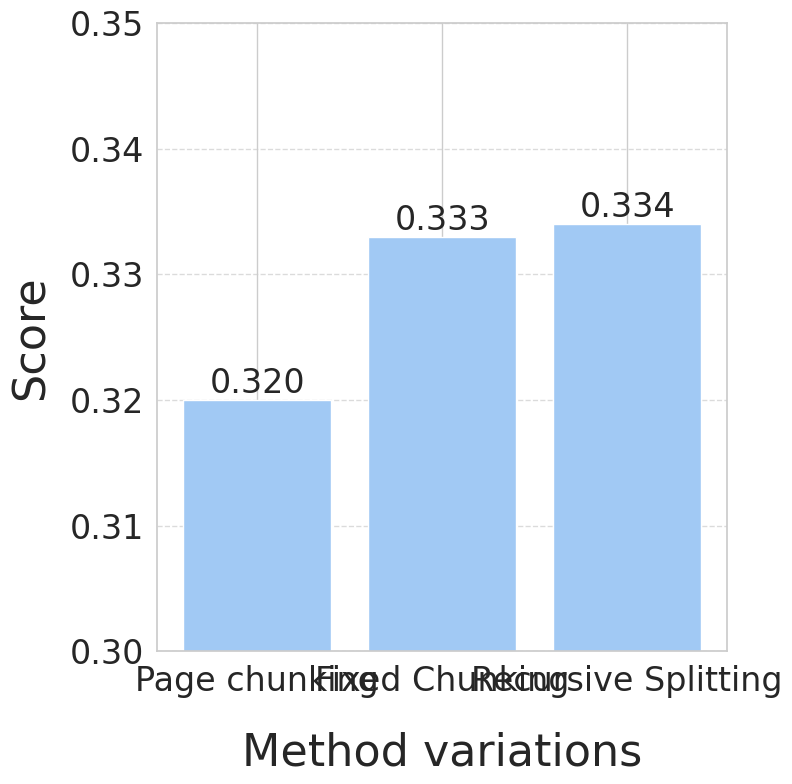

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_theme(style="whitegrid", palette="pastel")

labels = ["Page\nchunking", "Fixed\nChunking", "Recursive\nSplitting"]
title = "Chunking methods"
scores = [[0.329, 0.315, 0.320], [0.333, 0.328, 0.337], [0.334, 0.332, 0.335]]
scores = np.median(scores, axis=1)

# Create figure with appropriate size
plt.figure(figsize=(8, 8))

# Create bar plot
bars = plt.bar(labels, scores)

# Customize the plot
plt.ylabel('Score', fontsize=32, labelpad=12)
plt.xlabel('Method variations', fontsize=32, labelpad=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Set y-axis range
plt.ylim(0.3, 0.35)

# Set y-ticks to 4 evenly spaced labels
plt.yticks(np.linspace(0.3, 0.35, 6))

# Add value labels on top of each bar with larger font size
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom', fontsize=24)

# Adjust layout to prevent label cutoff
plt.tight_layout()